In [1]:
# 텐서플로 2 버전 선택
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import numpy as np

# 텍스트 감정분석

In [2]:
# 7.19 Naver Sentiment Movie Corpus v1.0 다운로드
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

4898816/4893335 [==============================] - 1s 0us/step


In [3]:
# 7.20 데이터 로드 및 확인
# 데이터를 메모리에 불러옵니다. encoding 형식으로 utf-8 을 지정해야합니다.
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

# 텍스트가 총 몇 자인지 확인합니다.
print('Length of text: {} characters'.format(len(train_text)))
print('Length of text: {} characters'.format(len(test_text)))
print()

# 처음 300 자를 확인해봅니다.
print(train_text[:300])

Length of text: 6937271 characters
Length of text: 2318260 characters

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [4]:
# 7.21 학습을 위한 정답 데이터(Y) 만들기
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])
print(train_Y.shape, test_Y.shape)
print(train_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]


In [5]:
# 7.22 train 데이터의 입력(X)에 대한 정제(Cleaning)
import re
# From https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()


train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


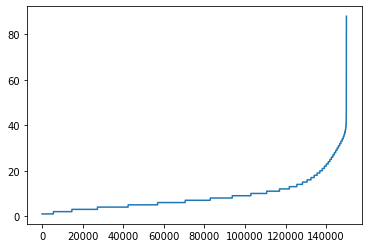

142587


In [6]:
# 7.23 각 문장의 단어 길이 확인 : y축이 문장의 단어 수, X축이 데이터의 수
import matplotlib.pyplot as plt
%matplotlib inline

sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

# model의 최대길이 자르기
print(sum([int(l<=25) for l in sentence_len]))

In [7]:
# 7.24 단어 정제 및 문장 길이 줄임  --> 위의 결과로 25개로 ㅋ컷을 정했으니..다 줄이기..
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new
# 25개 기준으로 해서, padding을 해서 채워놔야함
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [8]:
# 7.25 Tokenizer와 pad_sequences를 사용한 문장 전처리 --> 뒤에 비는 경우에는 padding 처리를 위해서 pad_sequence 사용!!!!
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(sentences)
train_X = tokenizer.texts_to_sequences(sentences)
# padding 앞을 채우냐 뒤로 채우나 다름
train_X = pad_sequences(train_X, padding='post')

print(train_X[:5])

[[   25   884     8  5795  1111     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  588  5796  6697     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   71   346    31    35 10468     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [  106  5338     4     2  2169   869   573     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


In [9]:
# 7.26 Tokenizer의 동작 확인
print(tokenizer.index_word[19999])
print(tokenizer.index_word[20000])

# 빈단어는 삭제되고 
temp = tokenizer.texts_to_sequences(['#$#$#', '경우는', '잊혀질', '연기가'])
print(temp)
temp = pad_sequences(temp, padding='post')
print(temp)

경우는
잊혀질
[[], [19999], [], [106]]
[[    0]
 [19999]
 [    0]
 [  106]]


In [10]:
# 7.27 감성 분석을 위한 모델 정의
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length=25),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 6,070,302
Trainable params: 6,070,302
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 7.28 감성 분석 모델 학습
history = model.fit(train_X, train_Y, epochs=5, batch_size=128, validation_split=0.2)

Train on 120000 samples, validate on 30000 samples
Epoch 1/5
120000/120000 [==============================] - 54s 449us/sample - loss: 0.4364 - accuracy: 0.7822 - val_loss: 0.3821 - val_accuracy: 0.8233
Epoch 2/5
120000/120000 [==============================] - 51s 429us/sample - loss: 0.3218 - accuracy: 0.8492 - val_loss: 0.3908 - val_accuracy: 0.8184
Epoch 3/5
120000/120000 [==============================] - 51s 429us/sample - loss: 0.2662 - accuracy: 0.8733 - val_loss: 0.4362 - val_accuracy: 0.8127
Epoch 4/5
120000/120000 [==============================] - 52s 432us/sample - loss: 0.2202 - accuracy: 0.8919 - val_loss: 0.4865 - val_accuracy: 0.8119
Epoch 5/5
120000/120000 [==============================] - 52s 432us/sample - loss: 0.1855 - accuracy: 0.9084 - val_loss: 0.5700 - val_accuracy: 0.8062


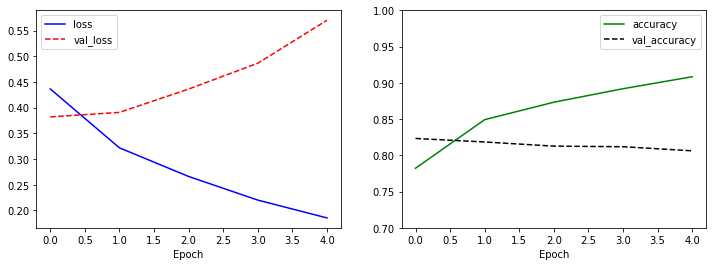

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [13]:
# 7.30 테스트 데이터 평가
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]
sentences = [sentence.split(' ') for sentence in test_text_X]
sentences_new = []
for sentence in sentences:
    sentences_new.append([word[:5] for word in sentence][:25])
sentences = sentences_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

model.evaluate(test_X, test_Y, verbose=0)

[0.5791219757413865, 0.79864]

In [14]:
# 7.31 임의의 문장 감성 분석 결과 확인 ( 부정0, 긍정1--> 입력 단어들을 늘려가면서 해당하는 감성 분석에 대한 결과가 어떻게 다르게 되는지..)
test_sentence = '재미있을 줄 알았는데 완전 실망했다. 너무 졸리고 돈이 아까웠다.'
test_sentence = test_sentence.split(' ')
test_sentences = []
now_sentence = []
for word in test_sentence:
    now_sentence.append(word)
    test_sentences.append(now_sentence[:])
    
test_X_1 = tokenizer.texts_to_sequences(test_sentences)
test_X_1 = pad_sequences(test_X_1, padding='post', maxlen=25)
prediction = model.predict(test_X_1)
for idx, sentence in enumerate(test_sentences):
    print(sentence)
    print(prediction[idx])

['재미있을']
[0.46754375 0.5324562 ]
['재미있을', '줄']
[0.4918131  0.50818694]
['재미있을', '줄', '알았는데']
[0.4670628  0.53293717]
['재미있을', '줄', '알았는데', '완전']
[0.50479156 0.4952084 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.']
[0.50479156 0.4952084 ]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무']
[0.6197774  0.38022265]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고']
[0.98375434 0.01624561]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이']
[0.99892163 0.00107837]
['재미있을', '줄', '알았는데', '완전', '실망했다.', '너무', '졸리고', '돈이', '아까웠다.']
[0.99892163 0.00107837]
